In [2]:
from google.cloud import storage
import os
import pandas as pd
from io import StringIO, BytesIO
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split

In [2]:
client = storage.Client(project='AIPI540')

In [3]:
bucket = client.get_bucket('aipi540-cv')


In [4]:
blob = bucket.blob('classification/trainLabels.csv')

In [5]:
csv_data = blob.download_as_text()
df = pd.read_csv(StringIO(csv_data))


In [6]:
df['level'] = df['level'].replace({2: 1, 3: 2, 4: 2})

In [7]:
from sklearn.model_selection import train_test_split
df_sampled, _ = train_test_split(
    df, test_size=len(df) - 4000, stratify=df["level"], random_state=42
)

In [8]:
df_sampled = df_sampled.reset_index().drop(columns='index')

In [9]:
def display_grayscale_images(images, titles=None):
    """
    Display an arbitrary number of grayscale images.
    
    Args:
    - images (list of np.array): List of grayscale images to display.
    - titles (list of str): Optional list of titles for the images.
    """
    num_images = len(images)
    titles = titles if titles else [f"Image {i + 1}" for i in range(num_images)]
    
    # Calculate grid size
    cols = 4
    rows = (num_images + cols - 1) // cols  # Ceiling division for rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis("off")
        else:
            ax.axis("off")  # Hide empty subplots

    plt.tight_layout()
    plt.show()


In [10]:
def iterative_thresholding(image: np.ndarray) -> np.ndarray:
    """
    Perform iterative thresholding on a grayscale image.
    
    Args:
    - image: np.ndarray, a 2D grayscale image with pixel values in [0, 255]
    
    Returns:
    - binary_image: np.ndarray, binary image with pixel values 0 or 255
    """
    # Normalize the intensity values to [0, 1]
    image_normalized = image / 255.0
    
    # Initial threshold: half of the maximum dynamic range (0.5 for normalized image)
    threshold = 0.5
    
    while True:
        # Separate foreground and background based on current threshold
        foreground = image_normalized[image_normalized >= threshold]
        background = image_normalized[image_normalized < threshold]
        
        # Compute the sample means for foreground and background
        mean_foreground = np.mean(foreground) if foreground.size > 0 else 0
        mean_background = np.mean(background) if background.size > 0 else 0
        
        # Compute the new threshold
        new_threshold = (mean_foreground + mean_background) / 2
        
        # Break if threshold convergence is achieved
        if np.abs(new_threshold - threshold) < 1e-5:
            break
        
        threshold = new_threshold

    # Apply the final threshold to generate the binary image
    binary_image = (image_normalized >= threshold).astype(np.uint8) * 255
    
    return binary_image


In [11]:
def remove_small_clusters(binary_image, min_size=20):
    # Step 1: Label connected components
    num_labels, labels = cv2.connectedComponents(binary_image)

    # Step 2: Create a new image to store the filtered components
    filtered_image = np.zeros_like(binary_image)

    # Step 3: Iterate through the components and check the size
    for label in range(1, num_labels):  # Start from 1 to ignore the background (label 0)
        # Create a mask for the current component
        component_mask = (labels == label)

        # Count the number of white pixels in the component
        component_size = np.sum(component_mask)

        # Step 4: If the component size is larger than min_size, keep it in the filtered image
        if component_size > min_size:
            filtered_image[component_mask] = 255  # Set the corresponding pixels to white

    return filtered_image


In [12]:
def download_images(dataframe, bucket):
    images = {}
    for img_filename in dataframe["image"]:
        blob_path = f"classification/resized_train/{img_filename}.jpeg"
        blob = bucket.blob(blob_path)
        data = blob.download_as_bytes()
        images[img_filename] = Image.open(BytesIO(data)).convert("RGB")
    return images


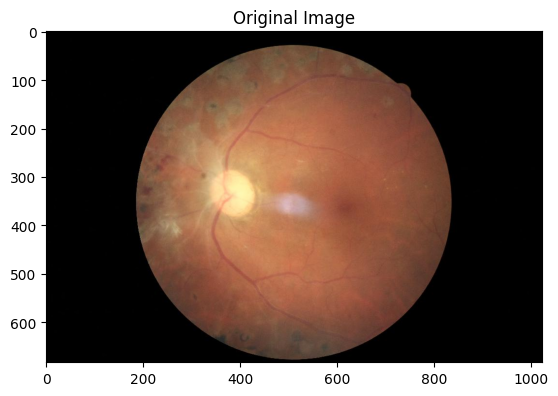

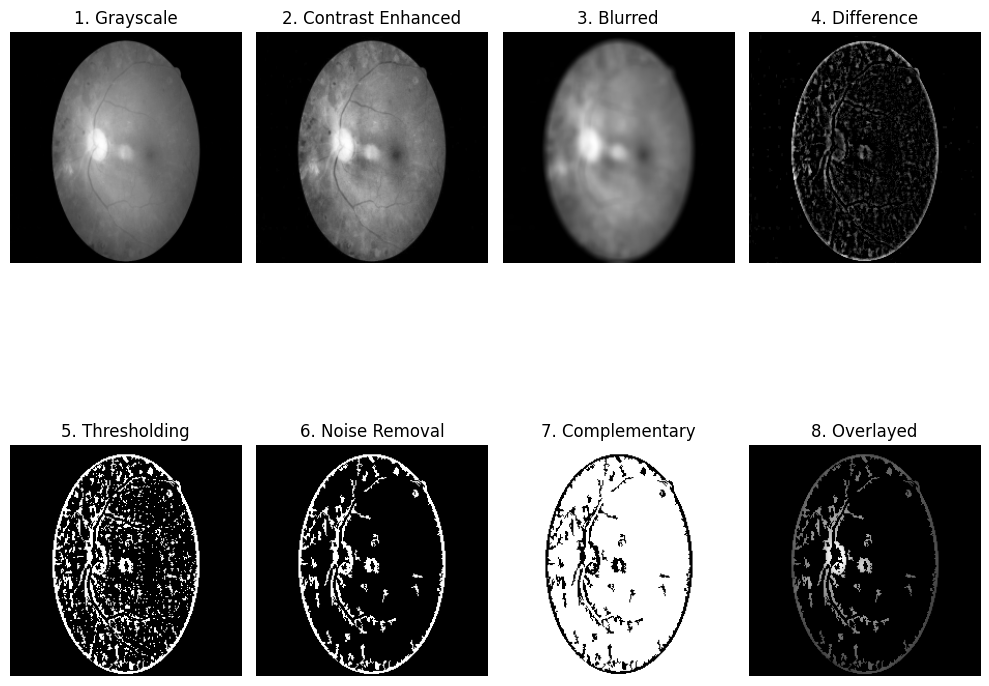

In [13]:
blob_path = f"classification/resized_train/294_left.jpeg"
blob = bucket.blob(blob_path)
data = blob.download_as_bytes()
pil_image = Image.open(BytesIO(data)).convert("RGB")
np_image = np.array(pil_image)
# plt.imshow(np_image)
img_resized = cv2.resize(np_image, (224,224), interpolation=cv2.INTER_AREA)
# gray_image = img_resized[:, :, 2]
gray_image = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
hist_eq = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray_image)
# hist_eq = cv2.equalizeHist(gray_image)
blur_img = cv2.blur(hist_eq, (7, 7))
subtracted = cv2.subtract(hist_eq, blur_img)
subtracted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(subtracted)
binary_image = iterative_thresholding(subtracted)
noise_removed = remove_small_clusters(binary_image)
complemented_binary = cv2.bitwise_not(noise_removed)
overlay_image = np.where(complemented_binary == 255, 0, gray_image)
plt.imshow(np_image)
plt.title(f"Original Image")
plt.show()
display_grayscale_images([gray_image, hist_eq, blur_img, subtracted, binary_image, noise_removed, complemented_binary, overlay_image], 
                         titles=['1. Grayscale', '2. Contrast Enhanced', '3. Blurred', '4. Difference', '5. Thresholding', '6. Noise Removal', '7. Complementary', '8. Overlayed'])

In [13]:
from sklearn.decomposition import PCA

def _apply_preprocessing(row):
    features = []
    img_filename = str(row["image"])
    print(img_filename)
    blob_path = f"classification/resized_train/{img_filename}.jpeg"
    blob = bucket.blob(blob_path)
    data = blob.download_as_bytes()
    pil_image = Image.open(BytesIO(data)).convert("RGB")
    np_image = np.array(pil_image)
    img_resized = cv2.resize(np_image, (224,224), interpolation=cv2.INTER_AREA)
    gray_image = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    hist_eq = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray_image)
    blur_img = cv2.blur(hist_eq, (7, 7))
    subtracted = cv2.subtract(hist_eq, blur_img)
    subtracted = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(subtracted)
    binary_image = iterative_thresholding(subtracted)
    noise_removed = remove_small_clusters(binary_image)
    complemented_binary = cv2.bitwise_not(noise_removed)
    overlay_image = np.where(complemented_binary == 255, 0, gray_image)
    features.extend(overlay_image.flatten())
    bin_size = 256 // 8
    quantized = (hist_eq // bin_size).astype(np.uint8)
    P = graycomatrix(quantized, [1,10,50], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=8, normed=True)
    features = []
    features.extend(graycoprops(P, 'contrast').mean(axis=1))
    features.extend(graycoprops(P, 'dissimilarity').mean(axis=1))
    features.extend(graycoprops(P, 'homogeneity').mean(axis=1))
    features.extend(graycoprops(P, 'energy').mean(axis=1))
    features.extend(graycoprops(P, 'correlation').mean(axis=1))
    features.extend(graycoprops(P, 'mean').mean(axis=1))
    features.extend(graycoprops(P, 'variance').mean(axis=1))
    features.extend(graycoprops(P, 'entropy').mean(axis=1))
    return features

feature_matrix = np.array(df_sampled.apply(_apply_preprocessing, axis=1).tolist())


30836_right
32070_right
6865_left
23770_right
37405_left
29423_right
12950_left
40921_left
39362_left
15343_right
40662_right
32486_right
19940_right
44053_left
10886_right
38957_right
13645_left
40144_left
25050_right
2774_left
7297_right
40787_left
16290_left
32057_right
16813_left
9358_left
15136_left
24668_left
10464_left
8316_right
4021_left
24221_right
27917_left
25238_right
1035_left
24270_left
30465_right
43966_left
14153_left
14306_right
18502_left
25043_right
1041_left
33227_right
702_left
23034_right
40551_right
26388_right
12652_right
5423_left
5963_right
5968_right
10773_left
9168_right
6793_left
36134_left
25153_left
33974_left
30748_left
6167_right
16807_right
6200_left
3873_left
25666_left
28586_right
4300_right
23133_right
39294_left
16238_right
25606_left
8462_left
5171_left
36985_left
5274_left
25260_right
2785_right
20200_right
22979_left
15534_right
4261_right
14486_left
21558_left
3347_left
24206_right
7563_left
9845_right
4998_right
16748_right
18517_left
32430_l

In [14]:
feature_df = pd.DataFrame(feature_matrix)

In [15]:
feature_df['label'] = df_sampled['level']

In [16]:
feature_df['label'].unique()

array([0, 1, 2])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(feature_df.iloc[:,:-1], feature_df.iloc[:,-1], test_size=0.2, stratify=feature_df.iloc[:,-1], random_state=0)

In [18]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [19]:
from sklearn.svm import LinearSVC
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)
from sklearn.metrics import f1_score
y_pred = lin_clf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')


0.6227377521613833

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'kernel': ['linear', 'rbf'],      # Type of kernel
    'gamma': ['scale', 'auto', 0.01, 0.1]  # Kernel coefficient
}

# Initialize the SVC
svc = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose= 2, scoring='f1_weighted')

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Display the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, 

In [26]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 50)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [27]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, scoring = 'f1_weighted', verbose=3, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=208;, score=0.624 total time=   1.5s
[CV 2/3] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=208;, score=0.622 total time=   1.6s
[CV 3/3] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=208;, score=0.623 total time=   1.6s
[CV 1/3] END max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=411;, score=0.620 total time=   4.5s
[CV 2/3] END max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=411;, score=0.622 total time=   4.5s
[CV 3/3] END max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=411;, score=0.622 total time=   4.7s
[CV 2/3] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=817;, score

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [5, 25, 45, 65, 86, 106,
                                                         126, 147, 167, 187,
                                                         208, 228, 248, 268,
                                                         289, 309, 329, 350,
                                                         370, 390, 411, 431,
                                                         451, 472, 492, 512,
                                                         532, 553, 573, 593, ...]},
                   random_state=42, scoring='f1_weighted', verbose=3)

In [31]:
rf_random.best_params_

{'n_estimators': 45,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40}

In [1]:
# Number of trees in random forest
n_estimators = [400,431,450]
# Maximum number of levels in tree
max_depth = [90,100,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [34]:
from sklearn.model_selection import GridSearchCV, train_test_split

# rf = RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, random_state=42)

# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs = -1)
# grid_search.fit(X_train, y_train)

In [32]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train, y_train)
base_pred = base_model.predict(X_test)
rs_pred = rf_random.predict(X_test)
# grid_pred = grid_search.predict(X_test)

print(f1_score(y_test, base_pred, average='weighted'))
print(f1_score(y_test, rs_pred, average='weighted'))
# print(f1_score(y_test, grid_pred, average='weighted'))

0.6229574190769368
0.6240327665531621


In [43]:
confusion_matrix(y_test, grid_pred)

array([[282,  12],
       [ 97,   9]])

In [35]:
from xgboost import XGBClassifier
# Define XGBoost model
xgb_model = XGBClassifier(eval_metric=f1_score)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearch for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and accuracy
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions and evaluate
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
Test Accuracy: 0.6227


In [41]:
import joblib

# Save the trained model to a .pkl file
model_filename = "xgboost_model.pkl"
joblib.dump(grid_search.best_estimator_, model_filename)
print(f"Model saved as {model_filename}")

Model saved as xgboost_model.pkl
